## Accelerating Vectors

This is part of pyxem, Hyperspy, py4DSTEM, xarray, etc., which is always a bit slower than it should be.  It's quite a shame, but it's a fairly difficult problem to solve. 

Let's start trying to chip away at the problem a little bit :) From the perspective of the entire field, this is another place where there is a lot of potential for future code development and having an underlying language for communicating between packages would be helpful. A lot of work was done with the [Ragged](https://github.com/scikit-hep/ragged) package but something like that requires a fair bit of devoted efforts.  

I'd love to see this as something that our community takes upon itself to solve!!!

In [1]:
#pip install pyinstrument

In [1]:
import hyperspy.api as hs
import pyxem as pxm

In [2]:
dp = pxm.data.sped_ag(lazy=True)
temp = dp.template_match_disk(disk_r=3, subtract_min=False)
dv = temp.get_diffraction_vectors(threshold_abs = 0.45, min_distance=2)

WARNING | Hyperspy | The function you applied does not take into account the difference of scales in-between axes. (hyperspy.signal:5487)
WARNING | Hyperspy | The function you applied does not take into account the difference of units in-between axes. (hyperspy.signal:5492)


In [3]:
dv.compute()

  0%|          | 0/53 [00:00<?, ?it/s]

In [4]:
import awkward as ak
import numpy as np
num = np.array([[int(len(v)) for v in vv ]for vv in dv.data])
ar = np.vstack([v for vv in dv.data for v in vv ])
a = ak.Array(ar)
awk_vectors = ak.unflatten(ak.unflatten(a, num.flatten()), num.shape[1])

def slice_ragged_vectors(vectors, roi):
    center = np.array([roi.cx, roi.cy, 0 ])[None, None,None] # Don't change the intensity
    shifted_vectors =  vectors - center
    distance = np.sqrt((shifted_vectors[:,:,:,0]**2+shifted_vectors[:,:,:,1]**2))
    is_in = ak.values_astype(distance<c.r, int)
    is_in = ak.values_astype(distance>c.r_inner, int) *is_in
    virtual_img = is_in  * vectors[:,:,:,2]
    virtual_img = np.sum(virtual_img, axis=-1)
    return hs.signals.Signal2D(virtual_img.to_numpy())

In [5]:
c = hs.roi.CircleROI(r=.4, cx=0, cy=0)

In [6]:
%%timeit 
slice_ragged_vectors(awk_vectors, c)

68.4 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
ar -  np.array([c.cx, c.cy, 0 ])

5.21 ms ± 96.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
center = np.array([c.cx, c.cy, 0 ])[None, None,None] # Don't change the intensity

In [9]:
center

array([[[[0., 0., 0.]]]])

In [10]:
%load_ext pyinstrument

In [11]:
%%timeit
difference = ar- np.array([c.cx, c.cy, 0 ])

5.18 ms ± 24.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
difference = ar- np.array([c.cx, c.cy, 0 ])

In [13]:
%%timeit
np.sqrt(np.sum(difference[:,:-1]**2, axis=1))

10.5 ms ± 77.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
dp

<LazyElectronDiffraction2D, title: , dimensions: (208, 64|112, 112)>

## So our baseline with numpy is ~15 ms

This is to find the distance between the center and some other point.  This seems pretty fast but this scales linearly with the size of the dataset. 

Yea 70.8 ms seems like it's pretty fast, but this dataset is only (208 * 64) = 13312 diffraction patterns... 


A 512 x 512 4D STEM scan is 20 times larger so that's ~1.4 seconds which is fast (but not live)....

a 2k x 2k 4D STEM scan is 320 times larger so that's ~22 seconds which is annoying.... 

For a 256 x 256 x 400 5D STEM scan that is ~143 seconds... Which is not live.

<Signal2D, title: , dimensions: (|208, 64)>

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:25:47  Samples:  40
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.077     CPU time: 0.078
/   _/                      v5.0.2

Cell [15]

0.077 <module>  /var/folders/zs/ggjk5_sn2yjgjq4_l93t8__r0000gn/T/ipykernel_34270/2735330094.py:1
`- 0.077 slice_ragged_vectors  /var/folders/zs/ggjk5_sn2yjgjq4_l93t8__r0000gn/T/ipykernel_34270/2599733351.py:8
   |- 0.039 Array.func  awkward/_operators.py:50
   |     [78 frames hidden]  awkward, <built-in>, numpy, <frozen a...
   |        0.019 Numpy._apply_ufunc_nep_50  awkward/_nplikes/array_module.py:270
   |        `- 0.017 [self]  awkward/_nplikes/array_module.py
   |- 0.030 Array.__getitem__  awkward/highlevel.py:676
   |     [19 frames hidden]  awkward, typing, <built-in>
   |- 0.004 Array.__array_function__  awkward/highlevel.py:1622
   |     [13 frames hidden]  awkward
   |- 0.002 Signal2D.__init__  hyperspy/_signals/signal2d.py:344
   |     [14 frames hidden]  hyperspy, traits, inspect, <built-in>
   |- 0.001 Array.__array_ufunc__  awkward/highlevel.py:1553
   |     [15 frames hidden]  awkward
   `- 0.001 dispatch  awkward/_dispatch.py:38
         [2 frames hidden]  awkward
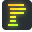

In [15]:
%%pyinstrument
slice_ragged_vectors(awk_vectors, c)

## Cheating is (almost) always the answer...

With making (any) code truly efficient, most likely you need to cheat :) 


- In the orientation mapping code in pyxem we transform to polar coordinates reducing the total number of patterns we need to match
- In the azimuthal integration code we first create a list of all of the polar bins, the pixels which contribute to each bin and then the fraction of that pixel inside the bin.

If you are going to reuse anything, compute it once and share it!  Electron microscopy is a little different than most  because you tend to have many many repetitions of the same thing. 


In [16]:
from scipy.spatial import KDTree

In [17]:
import hyperspy.api as hs

In [18]:
big_awk = np.concatenate([awk_vectors]*20)

In [19]:
%%timeit
slice_ragged_vectors(big_awk, c)

1.28 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
flattened = ak.flatten(ak.flatten(big_awk, axis=2), axis=1)

In [21]:
big_num_vectors_per_position = np.concatenate([num,]*20)

In [22]:
start_index_probe = np.cumsum(big_num_vectors_per_position.reshape(-1))

In [23]:
start_index_probe

array([      54,      110,      169, ..., 15487121, 15487180, 15487240])

In [24]:
flat_arr = flattened.to_numpy()

In [25]:
kdtree_flat = KDTree(flat_arr[:,:2]) # only x,y positions

In [26]:
%%timeit
indexes = kdtree_flat.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1

8.45 ms ± 84.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Trying something new....

Let's write this function, but the for loop in it is going to be slooowwww....

In [27]:
flat_arr = flattened.to_numpy()
kdtree_flat = KDTree(flat_arr[:,:2]) # only x,y positions

In [28]:
indexes = kdtree_flat.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_arr[indexes, 2]
virtual_image  = np.empty(len(start_index_probe))
for inten, ind in zip(intensities,indexes) :
    red_index =  np.searchsorted(start_index_probe, ind)
    virtual_image[red_index] += inten

virtual_image = virtual_image.reshape((1280, 208))

In [29]:
%%timeit
indexes = kdtree_flat.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_arr[indexes, 2]
virtual_image  = np.empty(len(start_index_probe))
for inten, ind in zip(intensities,indexes) :
    red_index =  np.searchsorted(start_index_probe, ind)
    virtual_image[red_index] += inten

virtual_image = virtual_image.reshape((1280, 208))

312 ms ± 602 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Well...

We are about 4 times faster which is nice but anytime you have a for loop in python it is going to be slow.  Maybe we can speed this up a little bit using numpy. 

In [30]:
flattened_num = big_num_vectors_per_position.flatten()
inds = np.arange(len(flattened_num))

In [31]:
all_indexes = np.repeat(inds, flattened_num)

In [32]:
%%timeit
indexes = kdtree_flat.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1

8.47 ms ± 30.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit
indexes = kdtree_flat.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1
intensities= flat_arr[indexes, 2]
red_indices = all_indexes[indexes]
virtual_image = np.bincount(red_indices, weights=intensities, minlength=len(start_index_probe))
virtual_image = virtual_image.reshape((1280, 208))

29.4 ms ± 438 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


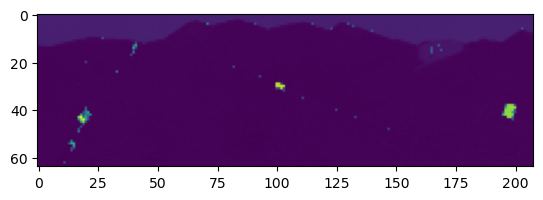

In [34]:
import matplotlib.pyplot as plt

plt.imshow(virtual_image[:64, :])

# We are down by a factor of ~40 from the 1.3 seconds we started with!

And all we have done is exploit numpy and some fun weird math with KD Trees.  We probably aren't going to go faster that a KD-Tree (although maybe there is something like a Quad tree that might be faster, considering our vectors are based on an x-y graph. 

Let's take things to numba... 

In [35]:
from numba import njit

@njit
def accumulate_virtual_image(indexes, vector_array, all_indexes, num_probes):
    virtual_image = np.zeros(num_probes, dtype=np.float64)

    for i in range(len(indexes)):
        ind = indexes[i]
        intensity = vector_array[ind, 2] # x, y, intensity
        red_index = all_indexes[ind]
        virtual_image[red_index] += intensity

    return virtual_image

In [36]:
indexes = kdtree_flat.query_ball_point([0,0], r=0.2, workers=1) # time to get all of the points within 0.2 A^-1

In [37]:
%%timeit
arr = accumulate_virtual_image(indexes, flat_arr, all_indexes, num_probes=len(flattened_num)).reshape((1280, 208))

175 ms ± 177 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Now what...

Unfortunately (fortunately??), ``numpy`` is pretty hard to beat these days even if you start writing cython code bincount is probably as good as you are going to get. 

Let's see where we are?

In [38]:
even_bigger_awkard_array = np.concatenate([np.concatenate([awk_vectors]*5, axis=1),]*20)

In [39]:
flattened = ak.flatten(ak.flatten(even_bigger_awkard_array, axis=2), axis=1)

In [40]:
inds = np.arange(len(flattened_num))

In [41]:
big_num_vectors_per_position = np.concatenate([np.concatenate([num]*5, axis=1),]*20)
flattened_num = big_num_vectors_per_position.flatten()
inds = np.arange(len(flattened_num))
all_indexes = np.repeat(inds, flattened_num)

In [42]:
flat = flattened.to_numpy()
kdtree_flat = KDTree(flat[:,:2]) # only x,y positions

In [43]:
%%timeit
kdtree_flat.query_ball_point([0,0], r=0.2) # still really fast...

44.7 ms ± 490 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%%timeit
indexes = kdtree_flat.query_ball_point([0,0], r=0.2) # time to get all of the points within 0.2 A^-1
intensities= flat[indexes, 2]
red_indices = all_indexes[indexes]
virtual_image = np.bincount(red_indices, weights=intensities, minlength=len(start_index_probe))
virtual_image = virtual_image.reshape((1280, 1040))

145 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
indexes = kdtree_flat.query_ball_point([0,0], r=0.2) # time to get all of the points within 0.2 A^-1

In [65]:
%%timeit
intensities= flat[indexes, 2]
red_indices = all_indexes[indexes]
virtual_image = np.bincount(red_indices, weights=intensities, minlength=len(start_index_probe))
virtual_image = virtual_image.reshape((1280, 1040))

104 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Thoughts and takeaways:

0.15 seconds for a virtual image that is ~1k x 1k is pretty good, but we want this a factor of 10x faster ~0.015 seconds for it to be considered "live".

Part of our problem is that the size of our array has grown.  We need better control and language to describe our list of vectors.  That and our kdtree is now large with lots of leaves... 

In [66]:
%%timeit
indexes = kdtree_flat.query_ball_point([0,0], r=.5) # time to get all of the points within 0.5 A^-1 
intensities= flat[indexes, 2]
red_indices = all_indexes[indexes]
virtual_image = np.bincount(red_indices, weights=intensities, minlength=len(start_index_probe))
virtual_image = virtual_image.reshape((1280, 1040))

2.55 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## And now things are slow(ish) again...

Maybe a KD Tree isn't the right thing to use, we are spending a lot of time calculating the same distances over and over and over again.  Let's sacrifice some of the absolute accuracy of a KDTree in favor of a pixel-by-pixel representation. 

Let's go back to the beginning and make an awkward array, this time in kx, ky.

In [92]:
indexes = kdtree_flat.query_ball_point([0,0], r=0.2) # time to get all of the points within 0.2 A^-1

array([[  2,   2],
       [ 25,   7],
       [ 51,  14],
       ...,
       [ 34, 108],
       [ 65, 108],
       [108, 108]])

In [ ]:
even_bigger_awkard_array

In [89]:
xy = ((flat[:,:2]-offset) //0.013364151943668684).astype(int)

In [90]:
xy

array([[  2,   2],
       [ 25,   7],
       [ 51,  14],
       ...,
       [ 34, 108],
       [ 65, 108],
       [108, 108]])

In [70]:
intens = even_bigger_awkard_array[:,:,:,2]

In [88]:
%%timeit
np.sum(intens[300:400, 300:400], axis=-1)

4.65 ms ± 14 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
%%timeit
ak.sum(intens, axis=-1)

360 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
import dask.array as da

In [80]:
%%timeit
np.ones((100,100,100,100)).sum(axis=(2,3))

109 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
offset = dp.axes_manager.signal_axes[0].offset

In [49]:
xy = ((flat[:,:2]-offset) //0.013364151943668684).astype(int)

In [61]:
vector_ind_by_pixel = 

array([[  2,   2],
       [ 25,   7],
       [ 51,  14],
       ...,
       [ 34, 108],
       [ 65, 108],
       [108, 108]])

In [60]:
%%timeit
arr = np.ones((112, 112))[xy[:,0],xy[:,1]]

329 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
arr.shape

(10,)

array([[-54., -54.],
       [-30., -49.],
       [ -4., -41.],
       ...,
       [-21.,  53.],
       [  9.,  53.],
       [ 53.,  53.]])

In [83]:
intensities

array([0.51995825, 0.48447521, 0.51995825, ..., 0.45502789, 0.45502789,
       0.5091177 ])

In [82]:
%%timeit
np.sum(intensities[10:40, 10:40])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [198]:
%%timeit
np.rint(flat)

216 ms ± 42.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
